In [1]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
class croptop(object):
    def __init__(self, amt) -> None:
        self.amt = amt
    def __call__(self, img):
        img = transforms.functional.crop(img, top = self.amt,left=0,width = img.shape[2],height =img.shape[1]-200)
        return img

In [3]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

root = "./../images/W084/"
transformation = transforms.Compose([transforms.ToTensor(),
                                     croptop(750),transforms.Resize((224,224)),
                                     
                                    ])
data = datasets.ImageFolder(root = root, transform=transformation)

evalloader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle = False)

In [4]:
model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False   

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2),
    torch.nn.Softmax(dim= 1)
)
model = torch.load("model.pth")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      TP = 0
      FP = 0
      TN = 0
      FN = 0
      val_loss = 0
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0])
                  else:
                        l = torch.tensor([0, 1])
                  l = l.reshape([1,2])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                 
                  if(predicted == 1 and true_label == 1):
                        TP +=1
                  elif(predicted == 0 and true_label == 0):
                        TN +=1
                  if(predicted == 1 and true_label == 0):
                        FP +=1
                        #plt.imsave(f"imageFP{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  elif(predicted == 0 and true_label == 1):
                        FN +=1
                        #plt.imsave(f"imageFN{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
            try:
                  precision = TP/(TP + FP)
            except:
                  precision = 0
            try:
                  recall = TP/(TP + FN)
            except:
                  recall = 0
            stats = dict(
                  epoch = epoch,
                  accuracy = (TN+TP) /(TP+TN+FP+FN),
                  precision = precision,
                  recall = recall,
                  loss = val_loss/(TP+FP+TN+FN)
            
            )
            print(f'True positives: {TP}')
            print(f'True negatives: {TN}')
            print(f'False positives: {FP}')
            
            print(f'False negatives: {FN}')
            return stats
calc_test_accuracy(model, evalloader, 0)

c:\Users\alxto\anaconda3\envs\sage\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


True positives: 1188
True negatives: 996
False positives: 383
False negatives: 209


{'epoch': 0,
 'accuracy': 0.7867435158501441,
 'precision': 0.7562062380649268,
 'recall': 0.8503937007874016,
 'loss': 0.5151957034399084}

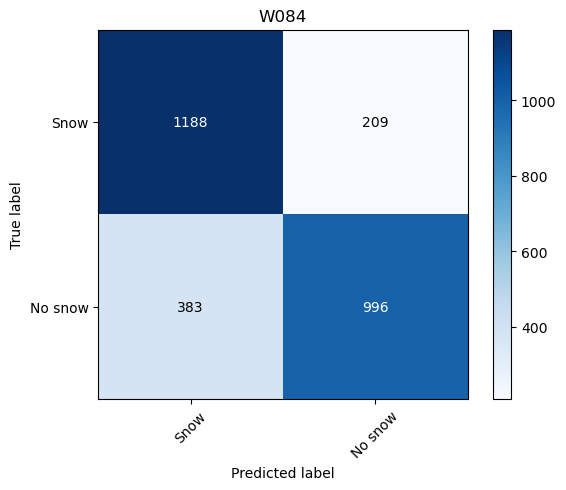

In [7]:

import matplotlib.pyplot as plt

# Example confusion matrix (replace this with your actual confusion matrix)
confusion_matrix = np.array([[1188, 209], [383, 996]])

# Define class labels (replace these with your class labels if you have them)
class_labels = ['Snow', 'No snow']

# Create a heatmap for the confusion matrix
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

# Set tick marks and labels for the plot
plt.xticks(np.arange(len(class_labels)), class_labels, rotation=45)
plt.yticks(np.arange(len(class_labels)), class_labels)

# Add annotations to each cell in the heatmap
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        color = 'black' if i != j else 'white'  
        plt.text(j, i, str(confusion_matrix[i, j]), ha='center', va='center', color=color)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('W084')
plt.show()
